### **Car Model Classification**
차 종(모델)의 분류는 일반적인 이미지 분류 예측 보다는 난이도가 있습니다. 예를 들어, 우리가 강아지와 사람을 분류 예측 해야 한다고 가정해봅시다. 사람의 이미지와 강아지의 이미지를 서로 비교해서 보면, 사람에게 드러나는 특징과 강아지에게 드러나는 특징은 비교적 차이가 존재합니다.

하지만, 자동차라는 하나의 카테고리의 이미지들 가운데, 심지어는 브랜드마저 같은 차량이 존재하는 이미지들 사이에서 차량의 모델을 분류하는 작업은 강아지와 사람을 구분하는 것 처럼 간단히 할 수 있는 문제가 아닙니다.

### **Competition**
이번 컴페티션에서는, 주어진 자동차 이미지를 총 196개의 클래스로 분류 예측하는 것이 목표입니다.  
sample_submission에 매핑된 테스트 이미지의 클래스를 예측하여 제출하시면 됩니다.



#### Data Description에 있는 파일 세부 정보입니다.
* **train.csv** - Train 셋의 이미지 파일명, 바운딩박스 좌표, 차종정보
* **test.csv** - Test 셋의 이미지 파일명, 바운딩박스 좌표, 차종정보
* **submission.csv** - Test셋과 대응되는 제출 파일
* **class.csv** - 데이터 셋의 class 컬럼과 대응되는 차종의 레이블
* **train** - Train 이미지 파일
* **test** - Test 이미지 파일

In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

Kernel 내용을 요약
1. Xception 사전 훈련 모델을 사용
2. resent 사전 훈련 모델을 사용
2. StratifiedKFold로 3 Fold로 나눠서 각 모델 훈련 및 검증 수행
3. 각 Fold 마다 val_loss가 가작 작게 나온 것에 대해서 Weight 파일로 저장
4. 훈련에서 나온 6개의 Weight로 예측 진행
5. 6개의 예측결과 평균(앙상블)

In [ ]:
import warnings
import seaborn as sns
import matplotlib.pylab as plt
import PIL
from sklearn.model_selection import StratifiedKFold, KFold

from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator

from keras.applications import Xception,ResNet50

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras import layers, models, optimizers

warnings.filterwarnings('ignore')
K.image_data_format()

# 변수 파라미터 사전 설정
image_size = 299
batch_size = 32
epochs = 100
k_fold=3


DATA_PATH = '../input'

train_iamge_path = os.path.join('../input/2019-3rd-ml-month-with-kakr/train')
test_iamge_path = os.path.join('../input/2019-3rd-ml-month-with-kakr/test')

df_train = pd.read_csv(os.path.join('../input/2019-3rd-ml-month-with-kakr/train.csv'))
df_test = pd.read_csv(os.path.join('../input/2019-3rd-ml-month-with-kakr/test.csv'))
df_class = pd.read_csv(os.path.join('../input/2019-3rd-ml-month-with-kakr/class.csv'))

df_train.head()

plt.figure(figsize=(12, 6))
sns.countplot(df_train["class"], order=df_train["class"].value_counts(ascending=True).index)
plt.title("Number of data per each class")
plt.show()

### **Class Distribution**  
분류 문제에서 가장 먼저 의심해봐야 할 부분이 바로 Target Class의 분포입니다. 학습에 사용해야 하는 Train Set의 타겟 분포를 확인해서 밸런스가 어느정도인지 체크해야 합니다.

119번 유형이 84개로 제일 많고,

136번 유형이 30개로 가장 적음.

각 차종별 평균 분포개수는 51개임.

In [ ]:
def crop_boxing_image(image_name,margin = -4, size=(image_size,image_size)):
    if image_name.split('_')[0] =='train':
        PATH = train_iamge_path
        data = df_train
    else:
        PATH = test_iamge_path
        data = df_test
    img = PIL.Image.open(os.path.join(PATH,image_name))
    pos = data.loc[data["img_file"]==image_name,['bbox_x1','bbox_y1','bbox_x2','bbox_y2']].values.reshape(-1)
    
    width ,height = img.size
    x1=max(0,pos[0]-margin)
    y1=max(0,pos[1]-margin)
    x2=max(pos[2]+margin,width)       
    y2=max(pos[3]+margin,height)
    
    return img.crop((x1,y1,x2,y2)).resize(size)

TRAIN_CROPPED_PATH = '../cropped_train'
TEST_CROPPED_PATH = '../cropped_test'

### **Bounding Box**

바운딩 박스란?  
이미지 내부에서 특정 Object를 박스로 레이블한 좌표를 말하며, 보통 좌측 상단 (x1, y1)과, 우측 하단 (x2, y2) 좌표가 주어져서   
직사각형 모양의 박스를 그릴 수 있게됩니다. 이때, 좌표는 이미지의 픽셀 좌표입니다.

In [ ]:
if (os.path.isdir(TRAIN_CROPPED_PATH)==False):
    os.mkdir(TRAIN_CROPPED_PATH)
if (os.path.isdir(TEST_CROPPED_PATH)==False):
    os.mkdir(TEST_CROPPED_PATH)    
for i,row in df_train.iterrows():
    cropped = crop_boxing_image(row['img_file'])
    cropped.save(os.path.join(TRAIN_CROPPED_PATH,row['img_file']))
for i,row in df_test.iterrows():
    cropped = crop_boxing_image(row['img_file'])
    cropped.save(os.path.join(TEST_CROPPED_PATH,row['img_file'])) 
    
df_train['class'] = df_train['class'].astype('str')
df_train = df_train[['img_file', 'class']]
df_test = df_test[['img_file']]
df_test.head()

model_path='./'

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

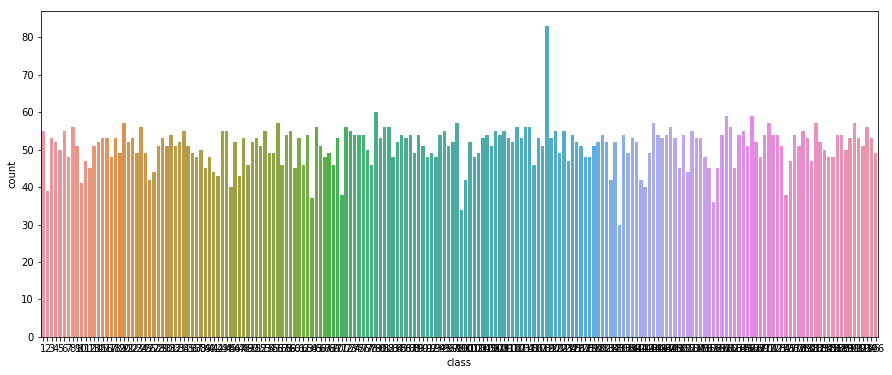

In [ ]:
def get_callback(model_name,patient):
    es = EarlyStopping(monitor='val_loss', patience=patient, mode = 'min', verbose= 1)
    rr = ReduceLROnPlateau(monitor= 'val_loss', factor=0.5, patience= patient/2,min_lr=0.000001,verbose=1,mode='min')
    mc = ModelCheckpoint(filepath=model_name,monitor='val_loss',verbose =1,save_best_only = True,mode = 'min')
    
    return [es,rr,mc]

def get_model_1(model_name_1,image_size):
    # base_model = application(weights='imagenet', input_shape=(image_size,image_size,3), include_top=False)
    base_model_1 = model_name_1(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
    # base_model.trainable = False

    model_1 = models.Sequential()
    model_1.add(base_model_1)
    model_1.add(layers.GlobalAveragePooling2D())
    model_1.add(layers.Dense(1024, activation='relu'))
    model_1.add(layers.Dropout(0.5))
    model_1.add(layers.Dense(196, activation='softmax'))
    model_1.summary()

    #optimizer = optimizers.SGD(lr=1e-4, decay=1e-6, momentum=0.9, nesterov=True)
    optimizer = optimizers.RMSprop(lr=0.0001)
    model_1.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

    return model_1

train_datagen = ImageDataGenerator(rescale = 1./255, rotation_range=30,width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True,vertical_flip= False,zoom_range= 0.3, shear_range= 0.3, fill_mode='nearest')
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

skf = StratifiedKFold(n_splits=k_fold,random_state=2019)

def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img
    return eraser

# <a id='4'><strong>Model</strong></a>
이제 본격적으로 이미지 분류 모델을 만들어 봅시다.  
이번 커널에서는 XGboost ,ResNet50 Pretrained Model을 불러와서 사용합니다.<br>
모델의 학습은 한번에 다 돌릴경우 시간이 많이 소요되어 **클라우드 환경에서 학습시킨 모델을 load**해 사용한다.


In [1]:
def get_model(model_name,image_size):
    base_model = model_name(weights = 'imagenet', input_shape = (image_size,image_size,3),include_top = False)
    model = models.Sequential()
    model.add(base_model)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(1024,activation='relu'))
    model.add(layers.Dropout(0.25))
    model.add(layers.Dense(1024,activation='relu'))
    model.add(layers.Dropout(0.25))
    model.add(layers.Dense(196,activation='softmax'))
    model.summary()
    optimizer = optimizers.RMSprop(lr=0.0001)
    model.compile(loss = 'categorical_crossentropy',optimizer = optimizer,metrics = ['acc'] )
    return model

In [ ]:
j = 1

for (train_index, valid_index) in skf.split( df_train['img_file'],  df_train['class']):
    traindf = df_train.iloc[train_index, :].reset_index()
    validdf = df_train.iloc[valid_index, :].reset_index()
    print("=========================================")
    print("====== K Fold Validation step => %d/%d =======" % (j,k_fold))
    print("=========================================")
    
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=traindf,
        directory=TRAIN_CROPPED_PATH,
        x_col='img_file',
        y_col='class',
        target_size= (image_size, image_size),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=batch_size,
        seed=2019,
        shuffle=True,
        preprocessing_function = get_random_eraser(v_l=0, v_h=255)
        )

    valid_generator = valid_datagen.flow_from_dataframe(
        dataframe=validdf,
        directory=TRAIN_CROPPED_PATH,
        x_col='img_file',
        y_col='class',
        target_size= (image_size, image_size),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=batch_size,
        seed=2019,
        shuffle=True
        )

### **Generator**

자, 제너레이터 입니다. 개인적으로 이미지 프로세싱에서 없어서는 안 될 필수 과정이라고 생각합니다. 정말 2번 3번 설명해도 부족함이 없습니다. 제너레이터가 왜 중요하고, 특히, 이번 컴페티션 혹은 딥러닝 파이프라인에서 어떤 효과가 있는지 잠깐 짚고 넘어가겠습니다.

#### **Generator의 이점?**
제너레이터는 코랩이나 캐글 커널같은 클라우드 환경 또는 일반적인 로컬 환경에서 정말 유용하게 쓰일 수 있습니다. 그 이유는 보통 이러한 환경은 메모리가 충분하지 않기 때문이죠. 특히나 이미지 처럼 파일하나의 용량이 매우 큰 경우, 한번에 모든 파일을 메모리에 적재하게 되면 상당히 큰 부담이 됩니다. 배치사이즈 단위 만큼 파일을 불러와 학습하고 끝나면 다시 불러와서 학습하는 방법을 반복하기 때문에 전체 학습을 하더라도 메모리를 조금만 사용하게 되는 것입니다.

### **Keras DataGenerator**
지금껏 불편하게 제너레이터를 만들어 사용했다면 케라스에는 정말 편한 제너레이터 함수가 있습니다. 케라스 ImageDataGenerator는 제너레이터의 기능은 물론 제너레이터를 정의하면서 동시에 Data에 원하는 Noise까지 부여할 수 있습니다. 또한 Documentaion을 참고하시면 생각보다 많은 기능이 있으니 이번 기회에 한번 사용해 보시는 것도 좋을 것 같네요.


In [ ]:
test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=TEST_CROPPED_PATH,
    x_col='img_file',
    y_col=None,
    target_size= (image_size, image_size),
    color_mode='rgb',
    class_mode=None,
    batch_size=batch_size,
    shuffle=False
)

In [ ]:
model_resnet_names = ['../input/output-11/1_resnet.hdf5','../input/output-11/2_resnet.hdf5','../input/output-11/3_resnet.hdf5']
model_xception_names = ['../input/output-11/1_xception.hdf5','../input/output-11/2_xception.hdf5','../input/output-11/3_xception.hdf5']

In [ ]:
resnet_xception_prediction = []
for i, name in enumerate(model_xception_names):
    model_xception = get_model(Xception, image_size)
    model_xception.load_weights(name)
    test_generator.reset()
    pred = model_xception.predict_generator(
        generator=test_generator,
        steps = len(df_test)/batch_size,
        verbose=1
    )
    resnet_xception_prediction.append(pred)

In [ ]:

y_pred_xception = np.mean(resnet_xception_prediction, axis=0)


In [ ]:
preds_class_indices=np.argmax(y_pred_xception, axis=1)

In [ ]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
final_pred = [labels[k] for k in preds_class_indices]

In [ ]:
submission = pd.read_csv(('../input/2019-3rd-ml-month-with-kakr/sample_submission.csv'))
submission["class"] = final_pred


In [ ]:
submission.to_csv("submission.csv", index=False)


In [ ]:
submission.head()